<a href="https://colab.research.google.com/github/Alam710/facial-emotion-recognition/blob/master/IMED_ExperimentDWCS48_100_epochs_augmentation_97%2C26_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Preparation for Classification (Original Image)
import os
from pathlib import Path

data_path = Path('/content/drive/MyDrive/IMED/cropped_data')
label_names = sorted([subfolder.name for subfolder in data_path.glob('*')])
num_classes = len(label_names)

class_counts = [0] * num_classes  # Initialize class counts

# Iterate over each label folder
for i, label_name in enumerate(label_names):
    label_path = data_path / label_name

    # Recursive function to count images in subfolders
    def count_images(folder):
        num_images = 0
        for item in folder.iterdir():
            if item.is_file() and item.suffix.lower() == '.jpg':
                num_images += 1
            elif item.is_dir():
                num_images += count_images(item)
        return num_images

    # Count the number of images within the label folder
    class_counts[i] = count_images(label_path)

# Print the number of images and classes
print('Number of classes:', num_classes)

# Print the number of images for each class
for i, label_name in enumerate(label_names):
    print(f'Class: {label_name}, Number of images: {class_counts[i]}')

Number of classes: 7
Class: 13_angry, Number of images: 1591
Class: 14_disgust, Number of images: 1413
Class: 15_fear, Number of images: 1550
Class: 16_happy, Number of images: 1322
Class: 17_sad, Number of images: 1793
Class: 18_surprise, Number of images: 1051
Class: 19_neutral, Number of images: 960


In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

data_path = Path('/content/drive/MyDrive/IMED/cropped_data')
label_names = sorted([subfolder.name for subfolder in data_path.glob('*')])
num_classes = len(label_names)
target_image_size = (48, 48)

# Create empty lists for images and labels
images = []
labels = []

# Recursive function to load images from subfolders
def load_images_from_folder(folder):
    for item in folder.iterdir():
        if item.is_dir():
            load_images_from_folder(item)
        elif item.is_file() and item.suffix.lower() == '.jpg':
            # Load the image in color
            image = cv2.imread(str(item))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize the image to the target size (224x224)
            image = cv2.resize(image, target_image_size)

            # Preprocess the image
            image = efficientnet_preprocess_input(image)

            # Append the image and label to the lists
            images.append(image)
            labels.append(label_names.index(folder.name))

# Iterate over each label folder
for label_name in label_names:
    label_path = data_path / label_name
    load_images_from_folder(label_path)

In [ ]:
# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, MaxPooling2D, Add, SeparableConv2D

def conv_block(inputs, filters, kernel_size, strides, padding='same'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu6')(x)
    return x

def residual_module(inputs, filters, num_blocks, strides):
    x = conv_block(inputs, filters, kernel_size=(1, 1), strides=strides)

    for _ in range(num_blocks):
        y = conv_block(x, filters, kernel_size=(3, 3), strides=(1, 1))
        y = conv_block(y, filters, kernel_size=(3, 3), strides=(1, 1))
        x = Add()([x, y])

    return x

def inverted_residual_structure(inputs, filters, num_blocks):
    x = conv_block(inputs, filters, kernel_size=(1, 1), strides=(1, 1))

    for _ in range(num_blocks):
        y = conv_block(x, filters, kernel_size=(3, 3), strides=(1, 1))
        y = conv_block(y, filters, kernel_size=(3, 3), strides=(1, 1))
        x = Add()([x, y])

    return x

input_shape = (target_image_size[0], target_image_size[1], 3)
num_classes = 7

inputs = tf.keras.Input(shape=input_shape)
x = conv_block(inputs, filters=32, kernel_size=(5, 5), strides=(1, 1))
x = MaxPooling2D(2, 2)(x)
x = conv_block(x, filters=64, kernel_size=(5, 5), strides=(1, 1))
x = MaxPooling2D(2, 2)(x)
x = residual_module(x, filters=128, num_blocks=2, strides=(2, 2))
x = inverted_residual_structure(x, filters=256, num_blocks=4)
x = residual_module(x, filters=256, num_blocks=2, strides=(2, 2))
x = residual_module(x, filters=364, num_blocks=1, strides=(1, 1))
x = residual_module(x, filters=364, num_blocks=2, strides=(2, 2))
x = inverted_residual_structure(x, filters=512, num_blocks=1)
x = SeparableConv2D(filters=728, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   2432        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 48, 48, 32)   0           ['batch_normalization[0][0]']

In [ ]:
# checkpoints
from tensorflow.keras.callbacks import ModelCheckpoint
weightpath = "model"
checkpoints = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callback_list = [checkpoints]

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
# TensorBoard Callbacks
callbacks = TensorBoard(log_dir='./Graph')

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.98):
      print("\nAkurasi telah mencapai > 98%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=0.01, mode='max', verbose=1)

# Train the model with early stopping
history_model = model.fit(X_train, y_train, epochs=100,
                          batch_size=32,
                          validation_data=(X_test, y_test),
                          callbacks=[callbacks])

Epoch 1/100
242/242 [==============================] - 49s 42ms/step - loss: 1.4938 - accuracy: 0.3760 - val_loss: 5.8797 - val_accuracy: 0.3053
Epoch 2/100
242/242 [==============================] - 7s 31ms/step - loss: 1.0585 - accuracy: 0.5919 - val_loss: 4.3458 - val_accuracy: 0.3967
Epoch 3/100
242/242 [==============================] - 9s 37ms/step - loss: 0.7942 - accuracy: 0.7151 - val_loss: 1.2968 - val_accuracy: 0.5604
Epoch 4/100
242/242 [==============================] - 8s 32ms/step - loss: 0.6557 - accuracy: 0.7654 - val_loss: 1.5487 - val_accuracy: 0.5883
Epoch 5/100
242/242 [==============================] - 9s 36ms/step - loss: 0.5029 - accuracy: 0.8257 - val_loss: 1.3085 - val_accuracy: 0.6798
Epoch 6/100
242/242 [==============================] - 9s 35ms/step - loss: 0.4047 - accuracy: 0.8639 - val_loss: 1.1785 - val_accuracy: 0.6684
Epoch 7/100
242/242 [==============================] - 8s 32ms/step - loss: 0.3190 - accuracy: 0.8927 - val_loss: 0.8010 - val_accuracy

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

61/61 [==============================] - 1s 9ms/step - loss: 0.1466 - accuracy: 0.9726
Test loss: 0.1465759426355362
Test accuracy: 0.9726239442825317


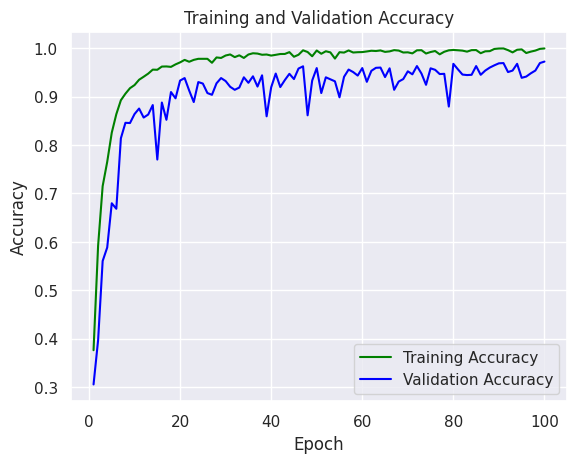

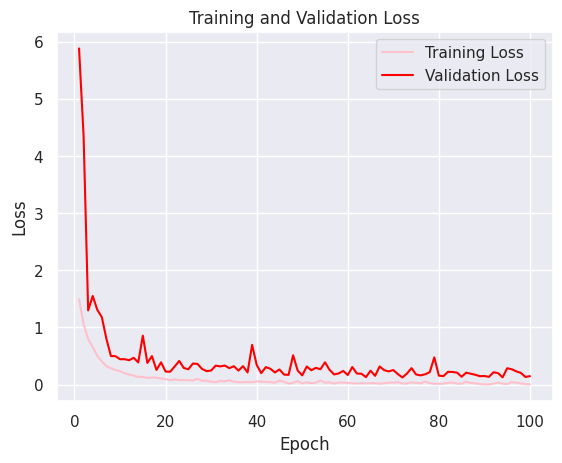

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history_model.history['accuracy']
val_acc = history_model.history['val_accuracy']
loss = history_model.history['loss']
val_loss = history_model.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
"""# Check which layers are trainable in our base model
for layer_number, layer in enumerate(base_model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)"""

'# Check which layers are trainable in our base model\nfor layer_number, layer in enumerate(base_model.layers[2].layers):\n  print(layer_number, layer.name, layer.trainable)'

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
preds_probs = model.predict(X_test, verbose=1)

61/61 [==============================] - 1s 7ms/step


In [ ]:
preds_probs[:10]

array([[4.56995804e-06, 3.87081491e-05, 9.99909043e-01, 1.66370182e-06,
        4.20753604e-05, 3.54545818e-06, 4.32367784e-07],
       [9.99984145e-01, 5.20381434e-07, 1.17020569e-07, 1.59812821e-08,
        1.42053132e-05, 6.15323586e-07, 3.99568648e-07],
       [1.38751284e-06, 1.91158028e-06, 2.91413335e-06, 3.79766298e-08,
        9.99993563e-01, 2.31219808e-08, 1.81218368e-07],
       [1.67297719e-06, 4.14882617e-09, 3.13107833e-08, 3.13834948e-06,
        4.59255318e-08, 9.99993682e-01, 1.39743543e-06],
       [9.99965310e-01, 2.43269787e-05, 3.55529073e-06, 2.90471576e-07,
        5.30385796e-06, 9.54705001e-07, 2.85564340e-07],
       [3.48705101e-14, 3.80850212e-12, 1.12240505e-13, 1.00000000e+00,
        5.02989374e-14, 2.40951092e-10, 1.10043667e-11],
       [8.22775328e-05, 3.45345633e-03, 9.96259212e-01, 3.72506179e-06,
        1.94858003e-04, 4.29196689e-06, 2.22936046e-06],
       [8.03456078e-06, 1.94488501e-04, 9.99791086e-01, 1.10007470e-07,
        2.43114346e-06, 2

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 7
What prediction probability sample 0 looks like:
 [4.5699580e-06 3.8708149e-05 9.9990904e-01 1.6637018e-06 4.2075360e-05
 3.5454582e-06 4.3236778e-07]
The class with the highest predicted probability by the model for sample 0: 2


In [ ]:
len(preds_probs)

1936

In [ ]:
preds_probs.shape

(1936, 7)

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([4.5699580e-06, 3.8708149e-05, 9.9990904e-01, 1.6637018e-06,
        4.2075360e-05, 3.5454582e-06, 4.3236778e-07], dtype=float32),
 7,
 1.0000000383073768)

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

In [ ]:
# How to they look?
pred_classes[:7]

array([2, 0, 4, 5, 0, 3, 2])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

1936

In [ ]:
#import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from sklearn import metrics

In [ ]:
y_test.shape, preds_probs.shape

((1936,), (1936, 7))

In [ ]:
#y_test = np.argmax(y_test, axis=1)

In [ ]:
preds_probs.shape , y_test.shape

((1936, 7), (1936,))

In [ ]:
y_test.shape

(1936,)

In [ ]:
preds_probs.shape

(1936, 7)

In [ ]:
preds_probs = np.argmax(preds_probs, axis=1)
preds_probs.shape

(1936,)

In [ ]:
print(metrics.accuracy_score(y_test, preds_probs))

0.9726239669421488


In [ ]:
print(classification_report(y_test, preds_probs))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       329
           1       0.98      0.97      0.98       277
           2       0.97      0.97      0.97       325
           3       0.98      0.98      0.98       259
           4       0.97      0.98      0.97       358
           5       0.97      0.95      0.96       204
           6       0.93      1.00      0.97       184

    accuracy                           0.97      1936
   macro avg       0.97      0.97      0.97      1936
weighted avg       0.97      0.97      0.97      1936



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.grid(False)  # Remove the grid lines
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

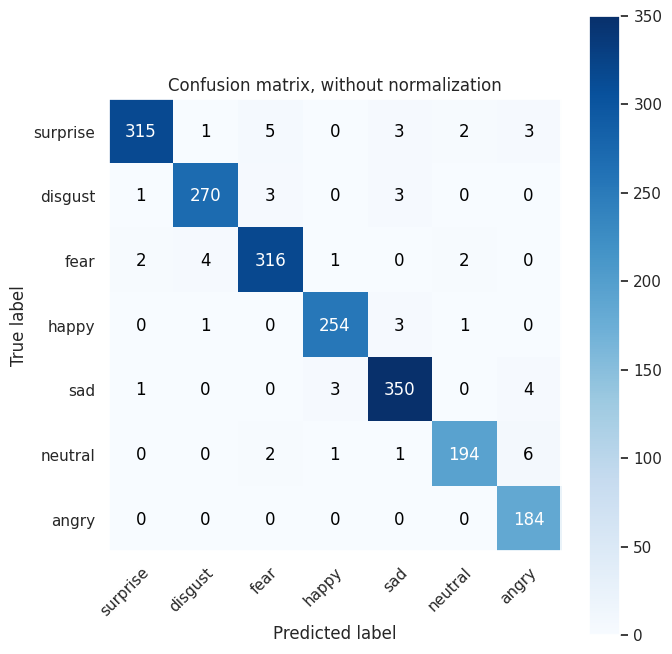

In [ ]:
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(y_test, preds_probs)
class_names=['surprise', 'disgust', 'fear', 'happy', 'sad', 'neutral', 'angry']
# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_test, preds_probs, classes = class_names, title='Confusion matrix, without normalization')

Normalized confusion matrix


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

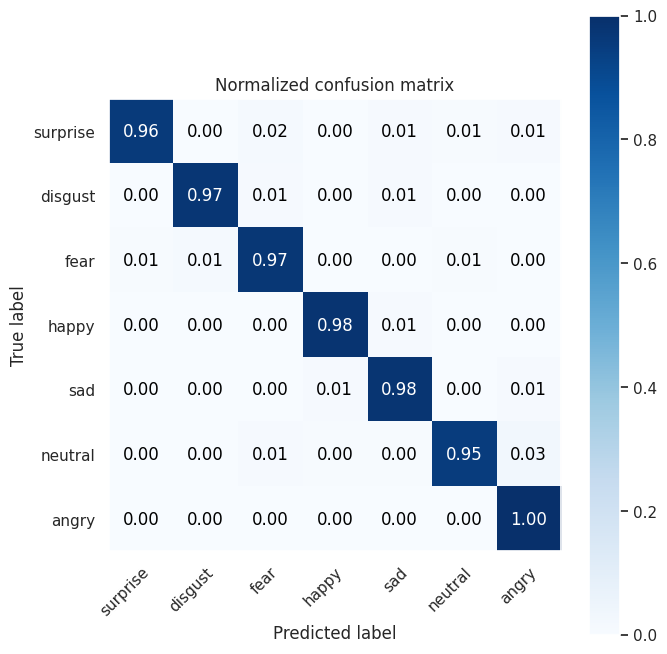

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(y_test, preds_probs, classes = class_names, normalize = True, title = 'Normalized confusion matrix')